6/23/2018

# P&S applied to King County Yelp Data.
This notebook plotss feature importaance from fitted RF model on random 80-20 train/test split and also plots one tree from fitted model. These figures correspond with the appendix figures.

In [2]:
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.model_selection import KFold
import re, ast
import platform
import sklearn.cross_validation
import matplotlib.pyplot as plt

execfile('../../functions/python_libraries.py')
execfile('../../functions/simulation_functions.py')

In [7]:
## Kang et al. data + Dan's additional data processing (Asian/non-Asian, year, etc.)
#dta = pd.read_csv('../../../data/KangData_with_additional_features.csv')
dta = pd.read_csv('/Users/kristen/Desktop/KangData_with_additional_features.csv')


## note there's observation with -1 inspection score. We set to 0.
dta.inspection_penalty_score[dta.inspection_penalty_score==-1]=0
dta.inspection_average_prev_penalty_scores[dta.inspection_average_prev_penalty_scores==-1]=0
dta.inspection_prev_penalty_score[dta.inspection_prev_penalty_score==-1]=0

/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
features = ['inspection_average_prev_penalty_scores', 'inspection_prev_penalty_score', # SAP
            'inspection_penalty_score', # y
            'asian', # SUP
            'poison', 'vomit','diarrhea', 'sick2', # CP
            'review_count', 'average_review_rating', 'non_positive_review_count'] # CP


ny_df_subset = dta[features]
ny_df_subset.columns

Index([u'inspection_average_prev_penalty_scores',
       u'inspection_prev_penalty_score', u'inspection_penalty_score', u'asian',
       u'poison', u'vomit', u'diarrhea', u'sick2', u'review_count',
       u'average_review_rating', u'non_positive_review_count'],
      dtype='object')

In [9]:
ny_df_subset.columns = ['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP',
                        'y',
                        'asian_SUP',
                        'poison_CP', 'vomit_CP','diarrhea_CP', 'sick_CP',
                        'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']

In [10]:
SAP_cols = [s for s in np.array(ny_df_subset.columns) if "SAP" in s]
print SAP_cols
CP_cols = [s for s in np.array(ny_df_subset.columns) if "CP" in s]
print CP_cols

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']


# One Train/Test Split for RF Model

In [11]:
clf = sklearn.ensemble.RandomForestRegressor()
max_depth = [3, 5, 10]
max_depth.append(None) 
min_samples_leaf = [5, 10, 20, 50, 100]
min_samples_split = [2, 3, 4, 5, 10] 
n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
max_features = ['auto', 0.25, 0.5, 0.75] 
random_grid = {'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'n_estimators': n_estimators,
              'min_samples_split': min_samples_split}

model = GridSearchCV(estimator = clf,
                param_grid = random_grid,
                cv = 3, verbose=0,
                n_jobs = -1)

In [12]:
k_fold = sklearn.cross_validation.ShuffleSplit(len(ny_df_subset.y), n_iter=1,
                                                         test_size=0.2,
                                                         random_state=0)

for k, (train, test) in enumerate(k_fold):
    print k
    df_subset_train = ny_df_subset.iloc[train,:]
    df_subset_test = ny_df_subset.iloc[test,:]


0


# Justify Hyperparameter Grid Range

In [13]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict
RANDOM_STATE = 123

ensemble_clfs = [
    ("RF, max_depth=3",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, oob_score=True,max_depth = 3,
                               max_features='auto',
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=5",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 5,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=10",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 10,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        #print i
        clf.set_params(n_estimators=i)
        clf.fit(df_subset_train[sum([SAP_cols, CP_cols, ['asian_SUP']], [])], 
                    df_subset_train.y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [14]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    plt.scatter(xs, ys)#, label=label)

plt.axvline(50, color = 'gray', alpha = 0.5, ls = '--')
plt.axvline(150, color = 'gray', alpha = 0.5, ls = '--')


plt.xlim(min_estimators, max_estimators)
plt.ylim(0.88, 0.96)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('King County (n_estimators)')
plt.legend(loc="upper right")

plt.tight_layout()
pp = PdfPages("./figs/KC_n_estimators_all_other_parameters_default.pdf")
pp.savefig()
pp.close()

# Feature Importance

In [15]:
print SAP_cols
print CP_cols
print ['asian_SUP']

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']
['asian_SUP']


In [16]:
# fit model
model.fit(df_subset_train[sum([SAP_cols, CP_cols, ['asian_SUP']], [])], 
                    df_subset_train.y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 0.25, 0.5, 0.75], 'n_estimators': [50, 100, 150], 'min_samples_split': [2, 3, 4, 5, 10], 'max_depth': [3, 5, 10, None], 'min_samples_leaf': [5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
imp = model.best_estimator_.feature_importances_
names = sum([SAP_cols, 
             CP_cols, ['asian_SUP']], [])

In [18]:
print names

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP', 'poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP', 'asian_SUP']


In [19]:
print SAP_cols
print CP_cols
names = ['avg. prior score',
                    'prior score','Number of reviews', '5-star rating', 'non-positive review count',
                         '``poison''', '``vomit''',
        '``diarrhea''', '``sick''', 
    
        'is Asian']

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']


In [24]:
from matplotlib.backends.backend_pdf import PdfPages


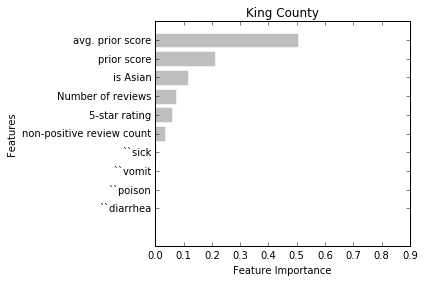

In [25]:
imp, names = zip(*sorted(zip(imp,names)))

%matplotlib inline
plt.barh(range(len(names)), imp, align = 'center', alpha = 0.5, edgecolor='white', color = 'gray')
plt.yticks(range(len(names)), names)
plt.xlabel('Feature Importance')
plt.title('King County')
plt.ylabel('Features')
plt.xlim(0,0.9)
plt.tight_layout()
pp = PdfPages('./figs/KingCounty_feature_importance.pdf')
pp.savefig()
pp.close()

In [26]:
print imp
print names

(0.0, 0.0, 0.0, 0.0008533654306649265, 0.035853324790189066, 0.0587459813094773, 0.07173554527523032, 0.1160148610878633, 0.2123811426777415, 0.5044157794288335)
('``diarrhea', '``poison', '``vomit', '``sick', 'non-positive review count', '5-star rating', 'Number of reviews', 'is Asian', 'prior score', 'avg. prior score')


# Visualize Decision Tree from RF Model

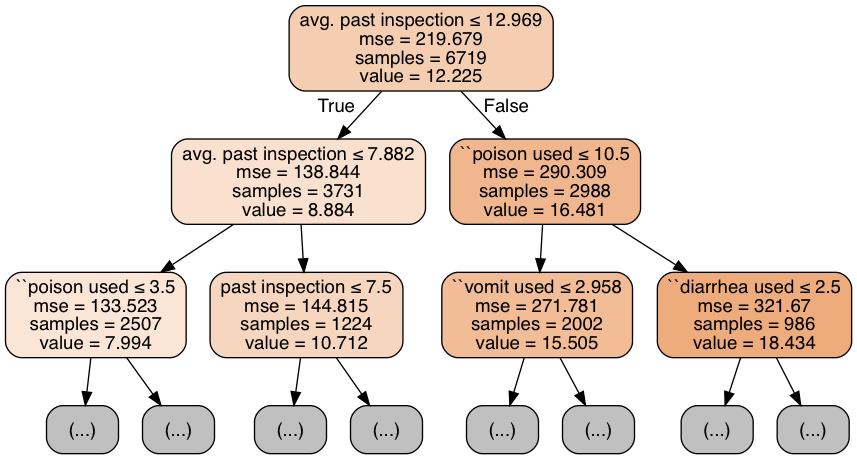

In [32]:
tree_id = 89

%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                max_depth = 2,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full_depth2.pdf")


Image(graph.create_png())



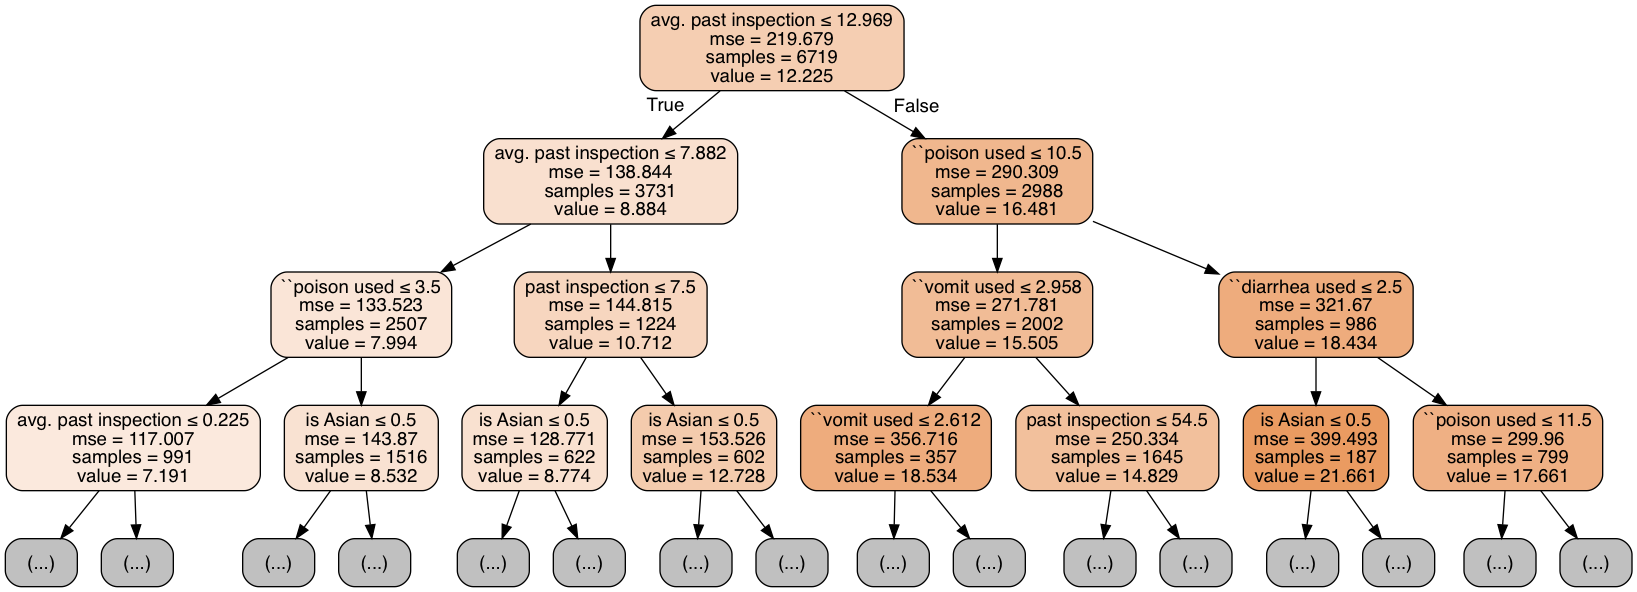

In [33]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names =['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                max_depth = 3,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full_depth_3.pdf")


Image(graph.create_png())




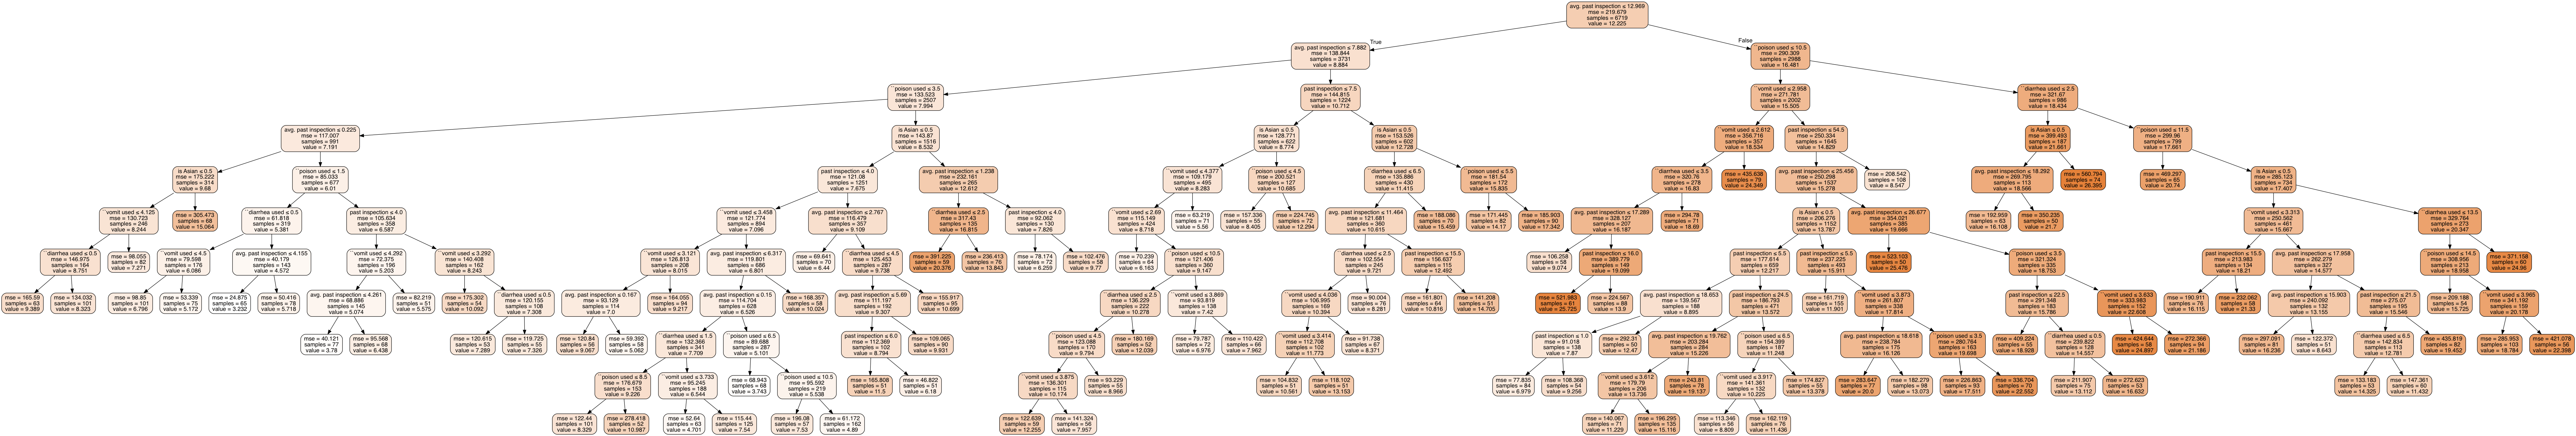

In [34]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                #max_depth = 4,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full.pdf")


Image(graph.create_png())


